In [1]:
import torch 
from torchvision import transforms
from PIL import Image
import time

#import torch.nn as nn
import torch.optim as optim
torch.autograd.set_detect_anomaly(True)
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

import math

import copy
from typing import Optional, List

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn, Tensor

from torch.nn.utils.rnn import pad_sequence

from scipy.optimize import linear_sum_assignment

from ortools.graph.python import min_cost_flow

from sklearn.manifold import TSNE
import copy

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        #print('PE',self.pos_embedding[:token_embedding.size(0), :])
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])
    
    
def collate_fn(batch_len,PAD_IDX,train=True,recon=False,run=12,path0='.'):
    #print('batch',len(batch),batch)
    src1_batch, src2_batch, y_batch,d_batch = [], [], [], []
    for j in range(batch_len):
        
        if train:
            E1,E2,A,D=loadgraph(path=path0)
        elif recon:
            E1,E2,A,D=loadgraph(recon=True, train=False,run=run,t_r=j,path=path0)
            #print('recon')
        else:
            E1,E2,A,D=loadgraph(train=False,path=path0)
        #print('src_sample',src_sample)
        src1_batch.append(E1)
        #print('emb',src_batch[-1])
        src2_batch.append(E2)
        y_batch.append(A)
        d_batch.append(D)
        
        
    #print('src_batch',src1_batch[3])
    #print('src2_batch',src2_batch[3])
    #print('src_batch s',len(src_batch))
    src1_batch = pad_sequence(src1_batch, padding_value=PAD_IDX)
    #print('src_batch',src_batch)
    #print('src_batch s',src_batch.size())
    src2_batch = pad_sequence(src2_batch, padding_value=PAD_IDX)
    
    
    #print('src1',src1_batch[:,0,:],src1_batch[:,0,:].size())
    #print('src2',src2_batch[:,0,:],src2_batch[:,0,:].size())
    #print('y',y_batch)
    ##
    return src1_batch, src2_batch,y_batch,d_batch


def loadgraph(train=True,run=None,easy=False,recon=False,t_r=None,path='.'):
    convert_tensor = transforms.ToTensor()
    if train:
        if run==None:
            run=np.random.randint(1,3) #!!!!!!!!!!##100 total data size
        else: run=run
        E=np.loadtxt('./'+str(run)+'/'+'embed.txt')
        #print('E',E.shape)
        id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
        A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
        D=np.loadtxt('./'+str(run)+'/'+'D.txt')
        bg=A[0]
        for i in range(len(A)):
            for j in range(len(A)):
                if i>j:
                    A[i,j]=0
        #A=A+np.eye(len(A), dtype=int)
        
        t = np.random.randint(30) #!!!!!!!!how many t??
        id1 = id[tt==t].astype(int)
        if t==0:
            id1=id1[1:]
        id2 = id[tt==(t+1)].astype(int)
        
        #print(run,t,id1,id2)
        
        E1 = E[id1-1]
        E2 = E[id2-1]
       
        E_bg = E[0]
        
        E1=np.concatenate((np.array([E_bg]), E1), axis=0)
        E2=np.concatenate((np.array([E_bg]), E2), axis=0)
        
     
        
        A=A[id1-1]
        
        A=A[:,id2-1]
        
        
        D=D[id1-1]
        D=D[:,id2-1]
        
        
        
       
        
        #print(bg[id1-1])
        #print(bg[id2-1])
        
        
        A=np.concatenate((np.array([bg[id2-1]]), A), axis=0)
        
        bg_a=np.append(1,bg[id1-1])
        #print(bg_a)
        A=np.concatenate((np.array([bg_a]).T, A), axis=1)
        
        bg_b = np.append(0,np.zeros(len(bg[id1-1])))
        
        D=np.concatenate((np.array([np.zeros(len(bg[id2-1]))]), D), axis=0)
        D=np.concatenate((np.array([bg_b]).T, D), axis=1)
        
        #print(D)
        #print(np.dot(E1,E2.T))
        
        
        
        
    else:
        #print('eval')
        if run==None:
            run=np.random.randint(1,3) #!!!!!!!!
        else: run=run
        E=np.loadtxt('./'+str(run)+'/'+'embed.txt')
        id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
        A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
        D=np.loadtxt('./'+str(run)+'/'+'D.txt')
        bg=A[0]
        for i in range(len(A)):
            for j in range(len(A)):
                if i>j:
                    A[i,j]=0
        #A=A+np.eye(len(A), dtype=int)
        
        t = np.random.randint(30) #!!!!!!!!how many t??
        id1 = id[tt==t].astype(int)
        if t==0:
            id1=id1[1:]
        id2 = id[tt==(t+1)].astype(int)
        
        #print(run,t,id1,id2)
        
        E1 = E[id1-1]
        E2 = E[id2-1]
       
        E_bg = E[0]
        
        E1=np.concatenate((np.array([E_bg]), E1), axis=0)
        E2=np.concatenate((np.array([E_bg]), E2), axis=0)
        
     
        
        A=A[id1-1]
        
        A=A[:,id2-1]
        
        #print(A)
        
        D=D[id1-1]
        D=D[:,id2-1]
        
       
        
        #print(bg[id1-1])
        #print(bg[id2-1])
        
        
        A=np.concatenate((np.array([bg[id2-1]]), A), axis=0)
        
        bg_a=np.append(1,bg[id1-1])
        A=np.concatenate((np.array([bg_a]).T, A), axis=1)
        
        bg_b = np.append(0,np.zeros(len(bg[id1-1])))
        
        D=np.concatenate((np.array([np.zeros(len(bg[id2-1]))]), D), axis=0)
        D=np.concatenate((np.array([bg_b]).T, D), axis=1)
        
        
    if recon: 
        run=run
        E=np.loadtxt('./'+str(run)+'/'+'embed.txt')
        id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
        A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
        D=np.loadtxt('./'+str(run)+'/'+'D.txt')
        for i in range(len(A)):
            for j in range(len(A)):
                if i>j:
                    A[i,j]=0
        #A=A+np.eye(len(A), dtype=int)
        
        
        #print(id)
        t = t_r
        id1 = id[tt==t].astype(int)
        if t==0:
            id1=id1[1:]
        id2 = id[tt==(t+1)].astype(int)
        
        #print(run,t,id1,id2)
        
        E1 = E[id1-1]
        E2 = E[id2-1]
       
        E_bg = E[0]
        
        E1=np.concatenate((np.array([E_bg]), E1), axis=0)
        E2=np.concatenate((np.array([E_bg]), E2), axis=0)
        
     
        
        A=A[id1-1]
        
        A=A[:,id2-1]
        
        
        
        D=D[id1-1]
        D=D[:,id2-1]
        
        
        #print(A)
        
        
        #print(bg[id1-1])
        #print(bg[id2-1])
        
        
        A=np.concatenate((np.array([bg[id2-1]]), A), axis=0)
        
        bg_a=np.append(1,bg[id1-1])
        A=np.concatenate((np.array([bg_a]).T, A), axis=1)
       
        #print(E1,E2)
        
        bg_b = np.append(0,np.zeros(len(bg[id1-1])))
    
    
    
        D=np.concatenate((np.array([np.zeros(len(bg[id2-1]))]), D), axis=0)
        D=np.concatenate((np.array([bg_b]).T, D), axis=1)
    
    
    if easy:
        n1=np.random.randint(3,6)
        n2=n1+np.random.randint(2)
        E1=np.ones((n1,6))
        E2=np.ones((n2,6))*3
        A=np.ones((n1,n2))
    
    
    
   
    
    D=D.astype(np.float32)
    
    vd = np.vectorize(d_mask_function,otypes=[float])
    
    D = vd(D,0.15,-2.0)
    
    
    E1=E1.astype(np.float32)
    E2=E2.astype(np.float32)
    A=A.astype(np.float32)
    #A=A.astype(np.float32)
    
    
    
    E1=convert_tensor(E1) 
    E2=convert_tensor(E2) 
    A=convert_tensor(A)
    D=convert_tensor(D)
    
    #print(E1[0].size(),E1[0])
    #print(E2[0].size(),E2[0])
    #print(A,A.size())
    #print('E',E.size())
    
    return E1[0],E2[0],A[0],D[0]

def create_mask(src,PAD_IDX):
    
    src= src[:,:,0]

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    #print('src_padding_mask',src_padding_mask,src_padding_mask.size())
    return src_padding_mask


def train_easy(model, optimizer, loss_function, epochs,scheduler,verbose=True,eval=True):
    
    model.train()
    
    loss_over_time = []
    test_error = []
    perf=[]
    t0 = time.time()
    i=0
    while i < epochs:
        print(i)
        
        #u = np.random.random_integers(4998) #4998 for 3_GT
        src1, src2, y = collate_fn(10,-100)
        
        #print('src_batch',src1)
        #print('src_batch s',src1.size())
        
        src_padding_mask1=create_mask(src1,-100)
        src_padding_mask2=create_mask(src2,-100)
        
        optimizer.zero_grad()
        
        '''#trysimplesttrans'''
        
        #output=model(tgt,tgt)
        
        
        
        output1,output2 = model(src1,src2,src_padding_mask1,src_padding_mask2)  
        #output = model(src)   #!!!!!!!
        #imshow(src1)
        #imshow(tgt1)
        
        #print('out1',output1,output1.size())
        #print('out2',output2,output2.size())
        
        

 
        #print('train_sizes',src.size(),output[:,:n_nodes,:n_nodes].size(),y.size())
        
        
        epoch_loss = loss_function(output1, src1)
        epoch_loss.backward()
        optimizer.step()
        scheduler.step()
        if i % 5 == 0 and i>0:
            t1 = time.time()
            epochs_per_sec = 10/(t1 - t0) 
            if verbose:
                print(f"Epoch: {i} loss {epoch_loss.item()} @ {epochs_per_sec} epochs per second")
            loss_over_time.append(epoch_loss.item())
            t0 = t1
            np.savetxt('./'+'train_loss.txt', np.c_[loss_over_time],delimiter='\t',header='trainloss')
            perf.append(epochs_per_sec)
        try:
            print(c)
            d=len(loss_over_time)
            if np.sqrt((np.mean(loss_over_time[d-10:-1])-np.mean(loss_over_time[d-20:d-10]))**2) < np.std(loss_over_time[d-10:-1])/50:
                print('loss not reducing')
                print(np.mean(loss_over_time[d-10:-1])-np.mean(loss_over_time[d-20:d-10]))
                print(np.std(loss_over_time[d-10:-1])/10)
                print(d)
                break
        except:
            pass
        
        i=i+1
        
        '''
        if i % 5 == 0 and i>0:
        
    
        
            if eval:
                u = np.random.random_integers(490)
                src_t, tgt_t, y_t = loadgraph(easy=True)
                
                n_nodes=0
                for h in range(len(src_t[0])):
                    if torch.sum(src_t[0][h])!=0:
                        n_nodes=n_nodes+1
                
                max_len=len(src_t[0])
                
                output_t = model(src_t,tgt_t,n_nodes)

                test_loss = loss_function(output_t[:,:n_nodes,:n_nodes], y_t)

                test_error.append(test_loss.item())
                
                np.savetxt('./'+'test_loss.txt', np.c_[test_error],delimiter='\t',header='testloss')

            
        
        i=i+1
            
    print('Mean Performance', np.mean(perf))
    return model, loss_over_time, test_error
    '''
        
        
class makeAdja:
    def __init__(self):
        pass
        
    def forward(self,z:Tensor,
                mask1: Tensor,
                mask2: Tensor):
        Ad = []
        for i in range(z.size(0)):
            n=len([i for i, e in enumerate(mask1[i]) if e != True])
            m=len([i for i, e in enumerate(mask2[i]) if e != True])
            Ad.append(z[i,0:n,0:m])
        
        
        return Ad
    
    
    
def train_epoch(model, optimizer,loss_fn):
    model.train()
    losses = 0
    
    src1, src2, y,d = collate_fn(31,-100)
        
    src1= src1.to(DEVICE)
    src2= src2.to(DEVICE)
    
    
    src_padding_mask1=create_mask(src1,-100)
    src_padding_mask2=create_mask(src2,-100)
    
    #print('src1',src1.size(),src1)
    
    #print('src1_mask',src_padding_mask1.size(),src_padding_mask1)
    #print('src1_0',src1[:,0,:].size(),src1[:,0,:])
    #print('src1_0_mask',src_padding_mask1.size(),src_padding_mask1[:,0,:])
    try:
        Ad,out1,out2,out_dec1,src1_t1,src2_t2 = model(src1,src2,src_padding_mask1,src_padding_mask2)
    except:    
        Ad = model(src1,src2,src_padding_mask1,src_padding_mask2)

    optimizer.zero_grad()

   
    loss = loss_fn.loss(Ad,y)
    
    #print(Ad[0],y[0])
    #print('l',loss)
    #print('l',loss.item() / len(src1))
    
    loss.backward()

    optimizer.step()
    losses += loss.item()
    
    

    return losses / len(src1)


def train_epoch_post_process(model, optimizer,loss_fn):
    model.train()
    losses = 0
    
    src1, src2, y,d = collate_fn(31,-100)
        
    src1= src1.to(DEVICE)
    src2= src2.to(DEVICE)
    
    src_padding_mask1=create_mask(src1,-100)
    src_padding_mask2=create_mask(src2,-100)
    
    Ad = model(src1,src2,src_padding_mask1,src_padding_mask2)
    
    Ad = complete_postprocess(Ad,d,0.01)

    optimizer.zero_grad()

   
    loss = loss_fn.loss(Ad,y)
    
    print(Ad[0])
    print(y[0])
    #print('l',loss)
    #print('l',loss.item() / len(src1))
    
    loss.backward()

    optimizer.step()
    losses += loss.item()
    
    

    return losses / len(src1)



class Loss():
    def __init__(self,pen,tra_to_tens=False):
        self.pen=pen
        self.trans=tra_to_tens
        
    def loss (self,Ad,y):
        convert_tensor = transforms.ToTensor()
        loss=0
        
        for i in range(len(Ad)):
            l = nn.CrossEntropyLoss()
            if self.trans:
                Ad[i]=convert_tensor(Ad[i])[0]
            #print(Ad[i], y[i])
            
            s = l(Ad[i], y[i])
            
            loss=loss+s
                
        if self.trans:
            loss = Variable(loss, requires_grad = True)
        return loss
    


def evaluate(model,loss_fn):
    #model.eval()
    losses = 0

    src1, src2, y,d = collate_fn(31,-100,train=False)
        
    src1= src1.to(DEVICE)
    src2= src2.to(DEVICE)
    
    src_padding_mask1=create_mask(src1,-100)
    src_padding_mask2=create_mask(src2,-100)
    
    try:
        Ad,out1,out2,out_dec1,src1_t1,src2_t2 = model(src1,src2,src_padding_mask1,src_padding_mask2)
    except:    
        Ad = model(src1,src2,src_padding_mask1,src_padding_mask2)

    
   
    loss = loss_fn.loss(Ad,y)
    
    losses += loss.item()
    
        

    return losses / len(src1)


def postprocess(A):
    pp_A=[]
    for i in range(len(A)):
        ind=torch.argmax(A[i], dim=0)
        B=np.zeros(A[i].shape)
        for j in range(len(ind)):
            B[ind[j],j]=1
        pp_A.append(B)
    return pp_A

def square(m):
    return m.shape[0] == m.shape[1]


def postprocess_2(Ad):
    pp_A=[]
    for h in range(len(Ad)):
        row_ind, col_ind = linear_sum_assignment(1-Ad[h].detach().numpy())

        z=np.zeros(Ad[h].shape)


        for i,j in zip(row_ind, col_ind):
            z[i,j]=1
    
        
        if square(z):
            pp_A.append(z)
            
        
        
        else:
            zero_col=np.where(~z.any(axis=0))[0]
            c_A=Ad[h].detach().numpy()
            z[:,zero_col] = c_A[:,zero_col]
            #print(z)
            pp_A.append(z)
        
            
       # else:
        #    z2 = np.zeros(Ad[h].shape)
        #    zero_col=np.where(~z.any(axis=0))[0]
            
         #   for k,l in zip(ind,zero_col):
         #       z2[k,l]=1
         #   pp_A.append(z+z2)  
        
    return pp_A



def postprocess_3(Ad):
    pp_A=[]
    
    row_ind, col_ind = linear_sum_assignment(1-Ad[0])
    
    print(1-Ad[0])
    print(row_ind, col_ind)
    
    z=np.zeros(Ad[0].shape)


    for i,j in zip(row_ind, col_ind):
        z[i,j]=1
    
    
    print(z)
    '''
    for h in range(len(Ad)):
        row_ind, col_ind = linear_sum_assignment(1-Ad[h])

        z=np.zeros(Ad[h].shape)


        for i,j in zip(row_ind, col_ind):
            z[i,j]=1
    
        
        if square(z):
            pp_A.append(z)
            
        
        
        else:
            zero_col=np.where(~z.any(axis=0))[0]
            c_A=Ad[h].detach().numpy()
            z[:,zero_col] = c_A[:,zero_col]
            #print(z)
            pp_A.append(z)
        
            
       # else:
        #    z2 = np.zeros(Ad[h].shape)
        #    zero_col=np.where(~z.any(axis=0))[0]
            
         #   for k,l in zip(ind,zero_col):
         #       z2[k,l]=1
         #   pp_A.append(z+z2) 
    '''
        
    return pp_A








def postprocess_linAss(Ad):
    pp_A=[]
    for h in range(len(Ad)):
        row_ind, col_ind = linear_sum_assignment(1-Ad[h].detach().numpy())

        z=np.zeros(Ad[h].shape)


        for i,j in zip(row_ind, col_ind):
            z[i,j]=1
    
        
        if square(z):
            pp_A.append(z)
        else:
            f=Ad[h].detach().numpy()
            l=np.ones(len(f))*2
            l=l.astype(int)
            
            
            f2=np.repeat(f, l, axis=0)
            row_ind, col_ind = linear_sum_assignment(1-f)
            z=np.zeros(f.shape)
            
            for i,j in zip(row_ind, col_ind):
                z[i,j]=1

            f2[0::2, :] = z[:] 

            row_ind_f, col_ind_f = linear_sum_assignment(1-f2)


            z3=np.zeros(f2.shape)


            for i,j in zip(row_ind_f, col_ind_f):
                z3[i,j]=1

            f_add = z3[0::2, :] + z3[1::2, :]
            
            pp_A.append(f_add)

        
    return pp_A





def postprocess_MinCostAss(Ad,a):
    pp_A=[]
    for h in range(len(Ad)):
        smcf = min_cost_flow.SimpleMinCostFlow()
        c_A = Ad[h]
        
        #left_n=c_A.size(0)
        #right_n=c_A.size(1)
        
        left_n=c_A.shape[0]
        right_n=c_A.shape[1]
        
        
        st=np.zeros(left_n)
        con= np.ones(right_n) 
        for v in range(left_n-1):
            con= np.append(con, np.ones(right_n)*(v+2))
        #print('con',con) 
        si = np.arange(left_n+1,left_n+right_n+1)
        start_nodes = np.concatenate((st,np.array(con),si))
        start_nodes = np.append(start_nodes,0)
        start_nodes = [int(x) for x in start_nodes ]
        #print(start_nodes)
        
        st_e = np.arange(1,left_n+1)
        con_e = si
        for j in range(left_n-1):
            con_e = np.append(con_e,si)
            
        si_e = np.ones(right_n)*left_n+right_n+1
        
        end_nodes = np.concatenate((st_e,np.array(con_e),si_e))
        end_nodes = np.append(end_nodes,si_e[-1])
        end_nodes = [int(x) for x in end_nodes ]
        #print(end_nodes)
        
        
        tasks = np.max([right_n,left_n])
        
        cap_0 = np.ones(left_n)
        cap_0[0]=right_n-1
        
        cap_left=np.ones(right_n)
        cap_left[0]=right_n
        
        capacities = np.concatenate((cap_0,np.ones(len(con_e)),cap_left))
        capacities = np.append(capacities,tasks)
        capacities = [int(x) for x in capacities]
        #print(capacities)
        
        '''
        c_A[0]=c_A[0]/c_A[0,0]
        c_A[0]=c_A[0]/(1.01*np.max(c_A[0]))
        c_A[:,0]=c_A[:,0]/c_A[0,0]
        c_A[:,0]=c_A[:,0]/(1.01*np.max(c_A[:,0]))
        '''
        
        #print(c_A)
        c= c_A.flatten()                          
        #c=torch.flatten(c_A)
        #c=c.detach().numpy()  
                                    
                                    
        c=(1-c)*10**4
        
        #print(c)
                                    
        costs = np.concatenate((np.zeros(left_n),c,np.zeros(right_n)))
        costs = np.append(costs,a*np.mean(c))                            
        costs = [int(x) for x in costs]
                                    
        #print(costs)
        
        source = 0
        sink = left_n+right_n+1
        
        supplies= tasks 
        
        supplies=np.append(supplies,np.ones(left_n))
        supplies=np.append(supplies,np.zeros(right_n))
        
        #supplies=np.append(supplies,np.zeros(left_n+right_n))
        
        supplies=np.append(supplies,-(tasks+left_n))
        
        supplies = [int(x) for x in supplies]
        #print(supplies)
        #print('____________________________________')
        # Add each arc.
        for i in range(len(start_nodes)):
            #print(start_nodes[i], end_nodes[i],capacities[i], costs[i])
            smcf.add_arc_with_capacity_and_unit_cost(start_nodes[i], end_nodes[i],
                                                 capacities[i], costs[i])
        # Add node supplies.
        for i in range(len(supplies)):
            smcf.set_node_supply(i, supplies[i])

        # Find the minimum cost flow between node 0 and node 10.
        status = smcf.solve()

        if status == smcf.OPTIMAL:
            #print('Total cost = ', smcf.optimal_cost())
            #print()
            row_ind=[]
            col_ind=[]
            for arc in range(smcf.num_arcs()):
                # Can ignore arcs leading out of source or into sink.
                if smcf.tail(arc) != source and smcf.head(arc) != sink:

                    # Arcs in the solution have a flow value of 1. Their start and end nodes
                    # give an assignment of worker to task.
                    if smcf.flow(arc) > 0:
                        #p#rint('Worker %d assigned to task %d.  Cost = %d Flow = %d' %
                        #      (smcf.tail(arc), smcf.head(arc), smcf.unit_cost(arc),smcf.flow(arc)))
                        row_ind.append(smcf.tail(arc)-1)
                        col_ind.append(smcf.head(arc)-left_n-1)
            z=np.zeros((left_n,right_n))
            
            for i,j in zip(row_ind, col_ind):
                z[i,j]=1
             
            
            #print('z_orig',z)
            s=np.sum(z,axis=1)
            for e in range(len(s)):
                if s[e]>1 and e!=0:
                    z[e,0]=0
            #print('z_bg_cor',z)      
            if (~z.any(axis=0)).any():
                z_col_ind=np.where(~z.any(axis=0))[0]
                z[:,z_col_ind]=c_A[:,z_col_ind]
                #print('---------z_0_col',z)
                z=postprocess_MinCostAss(np.array([z]),2*a)[0]
                #print('z_0_col_after',z)

                    
            pp_A.append(z)
                    
                #else:
                    #print('Worker %d assigned to task %d.  Cost = %d  Flow = %d' %
                      #    (smcf.tail(arc), smcf.head(arc), smcf.unit_cost(arc),smcf.flow(arc)))
                
        else:
            print('There was an issue with the min cost flow input.')
            print(f'Status: {status}')
          



    return pp_A

      
'''

    start_nodes = np.zeros(c_A.size(0)) + [
        1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3
    ] + [4, 5, 6, 7]
    end_nodes = [1, 2, 3] + [4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7] + [8,8,8,8]
    capacities = [2, 2, 2] + [
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
    ] + [2, 2, 2, 2]
    costs = (
        [0, 0, 0] +
        c +
        [0, 0, 0 ,0])

    source = 0
    sink = 8
    tasks = 4
    supplies = [tasks, 0, 0, 0, 0, 0, 0, 0, -tasks]

    # Add each arc.
    for i in range(len(start_nodes)):
        smcf.add_arc_with_capacity_and_unit_cost(start_nodes[i], end_nodes[i],
                                                 capacities[i], costs[i])
    # Add node supplies.
    for i in range(len(supplies)):
        smcf.set_node_supply(i, supplies[i])

    # Find the minimum cost flow between node 0 and node 10.
    status = smcf.solve()

    if status == smcf.OPTIMAL:
        print('Total cost = ', smcf.optimal_cost())
        print()
        for arc in range(smcf.num_arcs()):
            # Can ignore arcs leading out of source or into sink.
            if smcf.tail(arc) != source and smcf.head(arc) != sink:

                # Arcs in the solution have a flow value of 1. Their start and end nodes
                # give an assignment of worker to task.
                if smcf.flow(arc) > 0:
                    print('Worker %d assigned to task %d.  Cost = %d Flow = %d' %
                          (smcf.tail(arc), smcf.head(arc), smcf.unit_cost(arc),smcf.flow(arc)))
                    
                #else:
                    #print('Worker %d assigned to task %d.  Cost = %d  Flow = %d' %
                      #    (smcf.tail(arc), smcf.head(arc), smcf.unit_cost(arc),smcf.flow(arc)))
                
    else:
        print('There was an issue with the min cost flow input.')
        print(f'Status: {status}')
            pp_A.append(f_add)

        
    return pp_A

'''

def make_reconstructed_edgelist(A,run):
    
    e_start=[2,3,4]
    e1=[]
    e2=[]
    
    
    for i in range(len(A)):
        M=A[i]
        print('M0',M)
        X=M[0][1:]
        M=M[1:,1:]
        #print('M1',M)
        
        
        for z in range(len(M)):
            for j in range(len(M[0])):
                e_mid=np.arange(e_start[-1]+1,e_start[-1]+len(M[0])+1)
                if M[z,j]!=0:
                    #print(z,e_start)
                    e1.append(int(e_start[z]))
                    #print('e',e_mid)
                    e2.append(int(e_mid[j]))
                if z==0 and X[j]!=0:
                    e1.append(int(1))
                    e2.append(int(e_mid[j]))
                    
        
        e_start=e_mid
        #print('mid',e_mid)
    
    
    np.savetxt('./'+str(run)+'_GT'+'/'+'reconstruct.edgelist', np.c_[e1,e2], fmt='%i',delimiter='\t')
    return 0

def d_mask_function(x,r_core,alpha):
    if x < r_core:
        return 1
    else:
        return (x/r_core)**alpha
    
    
def complete_postprocess(Ad,d,a):
    
    Ad_n = []
    #Ad_n=copy.deepcopy(Ad)
    
    for h in range(len(Ad)):
        
        A_t,ill_flag=treshold(Ad[h],t=0.5)
        
        #print('ill_flag',ill_flag)
        #print(Ad[h],A_t)
        if ill_flag==True:
            Ad[h]=np.multiply(Ad[h].detach().numpy(),d[h].detach().numpy())
            A_t = postprocess_MinCostAss(np.array([Ad[h]]),a)[0]
            
        #print(Ad[h],A_t)
        Ad_n.append(A_t)
    #Ad=postprocess_MinCostAss(Ad)



    return Ad_n

def treshold(matrix, t):
    z=np.where(matrix >= t, 1, 0)
    
    ill_flag=False

      
    if (~z.any(axis=0)).any() or any(np.sum(z[:,1:], axis=0)>1):
        ill_flag=True
          
    return z,ill_flag

def err_perc(a,b):
    w=0
    s=0
    for i in range(len(a)):
        m=a[i]-b[i].detach().numpy()
        w=w+0.5*np.sum(np.abs(m))
        s=s+np.size(m)
    
    
    print('w,s',w,s)
    
    return w*100/s

In [3]:
a = np.array([[0.99, 0.87,0.05,0.08,0.77,0.11], [0.05, 0.12,0.19,0.11,0.14,0.93],[0.07, 0.12,0.45,0.89,0.23,0.05],[0.04, 0.1,0.97,0.65,0.34,0.02]])
print(a)

b = np.array([[1, 1,1,1,1,1], [1, 0.75,0.07,0.1,0.08,0.8],[1, 0.69,0.07,0.88,0.34,0.02],[1, 0.1,0.9,0.05,0.84,0.02]])
print(b)

print(np.multiply(a,b))
#print(threshold_matrix(a, 0.2))
print(a[:,1:])
print(any(np.sum(a[:,1:], axis=0)>1))
np.concatenate((a, b), axis=0)


#np.concatenate((a, b.T), axis=1)
c = np.array([[1, 0,0], [0, 1,0],[0, 0,1]])
d = np.array([[1, 0,0], [0, 0,1],[0, 0,1]])


m=c-d
print(np.sum(np.abs(m))/np.size(m))


c = torch.from_numpy(c).float()
d = torch.from_numpy(d).float()



cross_entropy_loss = nn.CrossEntropyLoss()

loss = cross_entropy_loss(c, d)

print(loss)

            


loadgraph(run=1)

#print(stop)

[[0.99 0.87 0.05 0.08 0.77 0.11]
 [0.05 0.12 0.19 0.11 0.14 0.93]
 [0.07 0.12 0.45 0.89 0.23 0.05]
 [0.04 0.1  0.97 0.65 0.34 0.02]]
[[1.   1.   1.   1.   1.   1.  ]
 [1.   0.75 0.07 0.1  0.08 0.8 ]
 [1.   0.69 0.07 0.88 0.34 0.02]
 [1.   0.1  0.9  0.05 0.84 0.02]]
[[9.900e-01 8.700e-01 5.000e-02 8.000e-02 7.700e-01 1.100e-01]
 [5.000e-02 9.000e-02 1.330e-02 1.100e-02 1.120e-02 7.440e-01]
 [7.000e-02 8.280e-02 3.150e-02 7.832e-01 7.820e-02 1.000e-03]
 [4.000e-02 1.000e-02 8.730e-01 3.250e-02 2.856e-01 4.000e-04]]
[[0.87 0.05 0.08 0.77 0.11]
 [0.12 0.19 0.11 0.14 0.93]
 [0.12 0.45 0.89 0.23 0.05]
 [0.1  0.97 0.65 0.34 0.02]]
True
0.2222222222222222
tensor(0.8848)


(tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.4513,  0.1221, -0.0285,  ...,  0.0232,  0.0256,  0.0393],
         [-0.5104,  0.1248, -0.0601,  ...,  0.0736,  0.0396, -0.0459],
         ...,
         [-0.6634,  0.2230, -0.1667,  ...,  0.0521, -0.0640, -0.0107],
         [-0.4996,  0.2267, -0.2140,  ...,  0.0140, -0.0024,  0.0838],
         [-0.6322,  0.2320, -0.1698,  ..., -0.0068,  0.0372,  0.0009]]),
 tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-5.5557e-01,  2.5337e-01, -2.3358e-01,  ...,  3.3732e-03,
          -3.7825e-02,  4.3635e-02],
         [-4.0343e-01,  1.7492e-01, -1.1902e-01,  ..., -6.7206e-04,
          -3.9526e-03,  1.7096e-02],
         ...,
         [-5.6323e-01,  2.0225e-01, -1.1524e-01,  ...,  4.7995e-03,
           5.9752e-02, -5.0799e-02],
         [-6.4361e-01,  2.8356e-01, -2.3510e-01,  ..., -7.7097e-02,
           1.3224e-01,  3.0098e-04],
         [-6.1588e-

In [1]:
class CAT(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 out = False, 
                 dim_feedforward: int = 512,
                 dropout: float = 0.05,
                 use_transformer: bool = True):
        super(CAT, self).__init__()
        
        
        
       
        decoder_layer = nn.TransformerDecoderLayer(d_model=emb_size, nhead=nhead,dim_feedforward=dim_feedforward)
        
        
        self.decoder_1_1 = nn.TransformerDecoder(decoder_layer, num_layers=num_encoder_layers)
        self.decoder_1_2 = nn.TransformerDecoder(decoder_layer, num_layers=num_encoder_layers)
        self.decoder_2_1 = nn.TransformerDecoder(decoder_layer, num_layers=num_encoder_layers)
        self.decoder_2_2 = nn.TransformerDecoder(decoder_layer, num_layers=num_encoder_layers)
        
        
        
        self.out=out 
        
        self.sig = torch.nn.Sigmoid()
        self.Ad = makeAdja()
        self.use_transformer=use_transformer
    def forward(self,
                src_t1: Tensor,
                src_t2: Tensor,
                src_padding_mask1: Tensor,
                src_padding_mask2: Tensor):
        
        #print('trans_src_before_pos',src_t1,src_t1.size())
        #print('trans_src_toke',self.src_tok_emb(src),self.src_tok_emb(src).size())
        
        if not self.use_transformer:  # <-- Add this condition
            src_t1_t = torch.transpose(src_t1, 0, 1)
            src_t2_t = torch.transpose(src_t2, 0, 1)
            src_t2_t = torch.transpose(src_t2_t, 1, 2)
            z = self.sig(torch.bmm(src_t1_t, src_t2_t))
            Ad = self.Ad.forward(z, src_padding_mask1, src_padding_mask2)
            return Ad
        
        src1_emb = src_t1
        src2_emb = src_t2
        #print('src1',src1_emb.size())
        #print('src2',src2_emb.size())
        #print('trans_src_padd',src_padding_mask1,src_padding_mask1.size())
        povi_1 = self.decoder_1_1(pos_1, vis_1,tgt_key_padding_mask=src_padding_mask2,memory_key_padding_mask=src_padding_mask1)
        povi_2 = self.decoder_1_2(pos_2, vis_2,tgt_key_padding_mask=src_padding_mask2,memory_key_padding_mask=src_padding_mask1)
        
        out_1 = self.decoder_2_1(povi_1, povi_2,tgt_key_padding_mask=src_padding_mask2,memory_key_padding_mask=src_padding_mask1)
        out_2 = self.decoder_2_2(povi_2, povi_1,tgt_key_padding_mask=src_padding_mask2,memory_key_padding_mask=src_padding_mask1)
        

        #out1=torch.transpose(out1,0,1)
        #out2=torch.transpose(out2,0,1)
        #out2=torch.transpose(out2,1,2)
        
        #z=self.sig(torch.bmm(out1,out2))
        
        
        out_1=torch.transpose(out_1,0,1)
        out_2=torch.transpose(out_2,0,1)
        out_2=torch.transpose(out_2,1,2)
        
        z=self.sig(torch.bmm(out_1,out_2))
        #print('z',z.size())
        
        Ad=self.Ad.forward(z,src_padding_mask1,src_padding_mask2)


        
        if self.out:
            return Ad,out1,out2,out_dec1,src_t1,src_t2
        else:
            return Ad


NameError: name 'nn' is not defined

In [11]:
input_dim=3

emb_size= 64 ###!!!!24 for n2v emb
nhead= 4    ####!!!! 6 for n2v emb
num_encoder_layers = 2


transformer = CAT(num_encoder_layers, emb_size, nhead)



for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = Loss(pen=0)


optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

print(stop)

NameError: name 'stop' is not defined

In [12]:
from timeit import default_timer as timer
NUM_EPOCHS = 2500

loss_over_time=[]
test_error=[]

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer,loss_fn)
    end_time = timer()
    val_loss = evaluate(transformer,loss_fn)
    
    
    loss_over_time.append(train_loss)
    np.savetxt('./'+'train_loss.txt', np.c_[loss_over_time],delimiter='\t',header='trainloss')
    
    test_error.append(val_loss)
                
    np.savetxt('./'+'test_loss.txt', np.c_[test_error],delimiter='\t',header='testloss')

    
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    
torch.save(transformer.state_dict(), 'AttTrack2_new.pt')


Epoch: 1, Train loss: 4.172, Val loss: 4.138, Epoch time = 1.739s
Epoch: 2, Train loss: 5.095, Val loss: 4.317, Epoch time = 1.505s
Epoch: 3, Train loss: 4.109, Val loss: 4.226, Epoch time = 1.464s
Epoch: 4, Train loss: 5.454, Val loss: 4.396, Epoch time = 1.562s
Epoch: 5, Train loss: 4.346, Val loss: 4.863, Epoch time = 1.787s
Epoch: 6, Train loss: 3.715, Val loss: 4.145, Epoch time = 1.723s
Epoch: 7, Train loss: 4.355, Val loss: 4.299, Epoch time = 1.554s
Epoch: 8, Train loss: 4.323, Val loss: 4.740, Epoch time = 1.623s
Epoch: 9, Train loss: 4.438, Val loss: 4.823, Epoch time = 1.752s
Epoch: 10, Train loss: 4.091, Val loss: 4.093, Epoch time = 1.754s
Epoch: 11, Train loss: 4.233, Val loss: 4.116, Epoch time = 1.769s
Epoch: 12, Train loss: 4.173, Val loss: 3.924, Epoch time = 1.732s
Epoch: 13, Train loss: 4.093, Val loss: 4.080, Epoch time = 1.668s
Epoch: 14, Train loss: 3.837, Val loss: 4.259, Epoch time = 1.670s
Epoch: 15, Train loss: 4.357, Val loss: 4.511, Epoch time = 1.695s
Epoc

Epoch: 124, Train loss: 3.884, Val loss: 4.183, Epoch time = 1.655s
Epoch: 125, Train loss: 4.299, Val loss: 4.316, Epoch time = 1.620s
Epoch: 126, Train loss: 4.396, Val loss: 4.571, Epoch time = 1.677s
Epoch: 127, Train loss: 3.554, Val loss: 3.828, Epoch time = 1.628s
Epoch: 128, Train loss: 3.831, Val loss: 4.330, Epoch time = 1.692s
Epoch: 129, Train loss: 3.615, Val loss: 3.380, Epoch time = 1.737s
Epoch: 130, Train loss: 3.594, Val loss: 4.384, Epoch time = 1.798s
Epoch: 131, Train loss: 4.471, Val loss: 3.594, Epoch time = 1.670s
Epoch: 132, Train loss: 3.543, Val loss: 3.418, Epoch time = 1.641s
Epoch: 133, Train loss: 3.425, Val loss: 3.367, Epoch time = 1.658s
Epoch: 134, Train loss: 3.871, Val loss: 3.613, Epoch time = 1.794s
Epoch: 135, Train loss: 3.257, Val loss: 4.045, Epoch time = 1.912s
Epoch: 136, Train loss: 4.534, Val loss: 3.597, Epoch time = 1.762s
Epoch: 137, Train loss: 3.651, Val loss: 3.288, Epoch time = 1.689s
Epoch: 138, Train loss: 4.180, Val loss: 4.123, 

Epoch: 245, Train loss: 3.583, Val loss: 3.615, Epoch time = 1.709s
Epoch: 246, Train loss: 3.546, Val loss: 4.374, Epoch time = 1.807s
Epoch: 247, Train loss: 3.097, Val loss: 3.466, Epoch time = 1.781s
Epoch: 248, Train loss: 3.467, Val loss: 3.476, Epoch time = 1.808s
Epoch: 249, Train loss: 3.354, Val loss: 2.981, Epoch time = 1.686s
Epoch: 250, Train loss: 3.892, Val loss: 3.553, Epoch time = 1.744s
Epoch: 251, Train loss: 3.275, Val loss: 4.143, Epoch time = 1.847s
Epoch: 252, Train loss: 3.655, Val loss: 4.102, Epoch time = 1.866s
Epoch: 253, Train loss: 3.645, Val loss: 3.988, Epoch time = 1.822s
Epoch: 254, Train loss: 3.322, Val loss: 4.117, Epoch time = 1.847s
Epoch: 255, Train loss: 3.117, Val loss: 3.459, Epoch time = 1.781s
Epoch: 256, Train loss: 3.177, Val loss: 4.136, Epoch time = 1.773s
Epoch: 257, Train loss: 3.228, Val loss: 3.449, Epoch time = 1.798s
Epoch: 258, Train loss: 3.867, Val loss: 3.122, Epoch time = 1.676s
Epoch: 259, Train loss: 3.937, Val loss: 3.570, 

Epoch: 366, Train loss: 3.936, Val loss: 3.414, Epoch time = 1.722s
Epoch: 367, Train loss: 3.163, Val loss: 3.332, Epoch time = 1.827s
Epoch: 368, Train loss: 3.903, Val loss: 3.637, Epoch time = 1.852s
Epoch: 369, Train loss: 3.689, Val loss: 3.319, Epoch time = 1.758s
Epoch: 370, Train loss: 3.107, Val loss: 3.087, Epoch time = 1.859s
Epoch: 371, Train loss: 3.303, Val loss: 3.474, Epoch time = 1.721s
Epoch: 372, Train loss: 3.814, Val loss: 3.121, Epoch time = 1.761s
Epoch: 373, Train loss: 3.680, Val loss: 3.186, Epoch time = 1.913s
Epoch: 374, Train loss: 3.056, Val loss: 3.354, Epoch time = 1.848s
Epoch: 375, Train loss: 3.821, Val loss: 3.763, Epoch time = 1.909s
Epoch: 376, Train loss: 3.801, Val loss: 3.622, Epoch time = 1.701s
Epoch: 377, Train loss: 3.294, Val loss: 3.395, Epoch time = 1.929s
Epoch: 378, Train loss: 3.418, Val loss: 3.938, Epoch time = 1.796s
Epoch: 379, Train loss: 3.399, Val loss: 3.211, Epoch time = 1.737s
Epoch: 380, Train loss: 3.730, Val loss: 3.466, 

Epoch: 487, Train loss: 2.960, Val loss: 3.001, Epoch time = 1.751s
Epoch: 488, Train loss: 3.324, Val loss: 3.340, Epoch time = 1.783s
Epoch: 489, Train loss: 3.945, Val loss: 3.096, Epoch time = 1.831s
Epoch: 490, Train loss: 3.760, Val loss: 4.070, Epoch time = 1.845s
Epoch: 491, Train loss: 3.904, Val loss: 3.352, Epoch time = 1.808s
Epoch: 492, Train loss: 3.398, Val loss: 4.156, Epoch time = 1.909s
Epoch: 493, Train loss: 3.784, Val loss: 3.239, Epoch time = 1.958s
Epoch: 494, Train loss: 3.325, Val loss: 3.894, Epoch time = 1.983s
Epoch: 495, Train loss: 3.187, Val loss: 2.991, Epoch time = 1.757s
Epoch: 496, Train loss: 3.115, Val loss: 3.282, Epoch time = 1.925s
Epoch: 497, Train loss: 3.410, Val loss: 4.087, Epoch time = 1.968s
Epoch: 498, Train loss: 3.430, Val loss: 3.012, Epoch time = 1.895s
Epoch: 499, Train loss: 3.244, Val loss: 3.410, Epoch time = 1.712s
Epoch: 500, Train loss: 3.345, Val loss: 3.131, Epoch time = 1.819s
Epoch: 501, Train loss: 3.418, Val loss: 3.134, 

Epoch: 608, Train loss: 3.361, Val loss: 3.212, Epoch time = 1.760s
Epoch: 609, Train loss: 2.930, Val loss: 4.024, Epoch time = 1.819s
Epoch: 610, Train loss: 2.986, Val loss: 3.987, Epoch time = 1.881s
Epoch: 611, Train loss: 3.855, Val loss: 3.331, Epoch time = 1.784s
Epoch: 612, Train loss: 3.478, Val loss: 3.298, Epoch time = 1.872s
Epoch: 613, Train loss: 3.173, Val loss: 3.206, Epoch time = 2.055s
Epoch: 614, Train loss: 3.559, Val loss: 3.133, Epoch time = 1.822s
Epoch: 615, Train loss: 2.853, Val loss: 3.154, Epoch time = 2.140s
Epoch: 616, Train loss: 2.779, Val loss: 3.677, Epoch time = 2.232s
Epoch: 617, Train loss: 3.227, Val loss: 3.455, Epoch time = 2.145s
Epoch: 618, Train loss: 3.080, Val loss: 3.545, Epoch time = 1.934s
Epoch: 619, Train loss: 3.402, Val loss: 3.002, Epoch time = 1.756s
Epoch: 620, Train loss: 3.120, Val loss: 3.931, Epoch time = 1.790s
Epoch: 621, Train loss: 3.659, Val loss: 3.454, Epoch time = 1.845s
Epoch: 622, Train loss: 3.269, Val loss: 3.060, 

Epoch: 729, Train loss: 3.083, Val loss: 2.943, Epoch time = 2.063s
Epoch: 730, Train loss: 3.148, Val loss: 2.686, Epoch time = 1.930s
Epoch: 731, Train loss: 2.874, Val loss: 2.915, Epoch time = 1.954s
Epoch: 732, Train loss: 3.638, Val loss: 3.185, Epoch time = 1.955s
Epoch: 733, Train loss: 3.833, Val loss: 3.004, Epoch time = 2.065s
Epoch: 734, Train loss: 3.577, Val loss: 3.013, Epoch time = 2.058s
Epoch: 735, Train loss: 3.315, Val loss: 3.434, Epoch time = 2.015s
Epoch: 736, Train loss: 3.369, Val loss: 3.036, Epoch time = 2.098s
Epoch: 737, Train loss: 2.906, Val loss: 3.208, Epoch time = 2.026s
Epoch: 738, Train loss: 3.018, Val loss: 2.912, Epoch time = 2.246s
Epoch: 739, Train loss: 2.649, Val loss: 2.835, Epoch time = 2.023s
Epoch: 740, Train loss: 3.485, Val loss: 2.817, Epoch time = 1.967s
Epoch: 741, Train loss: 3.514, Val loss: 3.262, Epoch time = 2.002s
Epoch: 742, Train loss: 3.023, Val loss: 2.806, Epoch time = 2.012s
Epoch: 743, Train loss: 3.819, Val loss: 3.777, 

Epoch: 850, Train loss: 2.937, Val loss: 3.166, Epoch time = 2.052s
Epoch: 851, Train loss: 2.818, Val loss: 3.265, Epoch time = 1.998s
Epoch: 852, Train loss: 3.633, Val loss: 3.938, Epoch time = 1.955s
Epoch: 853, Train loss: 2.963, Val loss: 3.564, Epoch time = 1.991s
Epoch: 854, Train loss: 3.420, Val loss: 3.299, Epoch time = 1.965s
Epoch: 855, Train loss: 3.251, Val loss: 3.151, Epoch time = 1.809s
Epoch: 856, Train loss: 3.641, Val loss: 2.912, Epoch time = 1.854s
Epoch: 857, Train loss: 3.247, Val loss: 2.943, Epoch time = 1.875s
Epoch: 858, Train loss: 3.423, Val loss: 3.416, Epoch time = 1.988s
Epoch: 859, Train loss: 2.675, Val loss: 2.810, Epoch time = 1.958s
Epoch: 860, Train loss: 3.093, Val loss: 3.415, Epoch time = 1.799s
Epoch: 861, Train loss: 3.074, Val loss: 3.112, Epoch time = 1.798s
Epoch: 862, Train loss: 3.429, Val loss: 3.059, Epoch time = 1.898s
Epoch: 863, Train loss: 3.033, Val loss: 3.056, Epoch time = 1.947s
Epoch: 864, Train loss: 2.975, Val loss: 2.717, 

Epoch: 971, Train loss: 2.713, Val loss: 3.223, Epoch time = 2.443s
Epoch: 972, Train loss: 3.026, Val loss: 3.117, Epoch time = 2.677s
Epoch: 973, Train loss: 2.915, Val loss: 2.956, Epoch time = 2.265s
Epoch: 974, Train loss: 3.523, Val loss: 3.026, Epoch time = 2.426s
Epoch: 975, Train loss: 3.479, Val loss: 3.087, Epoch time = 1.999s
Epoch: 976, Train loss: 2.660, Val loss: 2.965, Epoch time = 1.813s
Epoch: 977, Train loss: 3.582, Val loss: 4.129, Epoch time = 1.906s
Epoch: 978, Train loss: 2.892, Val loss: 2.931, Epoch time = 1.997s
Epoch: 979, Train loss: 3.228, Val loss: 3.029, Epoch time = 2.227s
Epoch: 980, Train loss: 3.142, Val loss: 3.098, Epoch time = 1.954s
Epoch: 981, Train loss: 3.023, Val loss: 3.123, Epoch time = 2.039s
Epoch: 982, Train loss: 3.143, Val loss: 2.948, Epoch time = 2.085s
Epoch: 983, Train loss: 2.848, Val loss: 3.349, Epoch time = 1.991s
Epoch: 984, Train loss: 2.463, Val loss: 3.335, Epoch time = 2.194s
Epoch: 985, Train loss: 3.298, Val loss: 2.988, 

Epoch: 1091, Train loss: 2.929, Val loss: 3.550, Epoch time = 1.932s
Epoch: 1092, Train loss: 2.669, Val loss: 3.289, Epoch time = 2.005s
Epoch: 1093, Train loss: 2.819, Val loss: 3.266, Epoch time = 1.872s
Epoch: 1094, Train loss: 2.905, Val loss: 3.565, Epoch time = 1.853s
Epoch: 1095, Train loss: 2.984, Val loss: 3.367, Epoch time = 1.864s
Epoch: 1096, Train loss: 2.647, Val loss: 2.829, Epoch time = 2.154s
Epoch: 1097, Train loss: 3.046, Val loss: 3.507, Epoch time = 2.120s
Epoch: 1098, Train loss: 3.447, Val loss: 3.334, Epoch time = 1.921s
Epoch: 1099, Train loss: 2.704, Val loss: 2.885, Epoch time = 1.964s
Epoch: 1100, Train loss: 2.725, Val loss: 2.915, Epoch time = 1.965s
Epoch: 1101, Train loss: 2.785, Val loss: 3.453, Epoch time = 2.001s
Epoch: 1102, Train loss: 3.825, Val loss: 3.279, Epoch time = 1.951s
Epoch: 1103, Train loss: 2.903, Val loss: 3.157, Epoch time = 2.099s
Epoch: 1104, Train loss: 3.020, Val loss: 2.548, Epoch time = 2.048s
Epoch: 1105, Train loss: 2.945, Va

Epoch: 1210, Train loss: 2.921, Val loss: 2.965, Epoch time = 1.851s
Epoch: 1211, Train loss: 3.466, Val loss: 3.286, Epoch time = 1.893s
Epoch: 1212, Train loss: 3.045, Val loss: 2.771, Epoch time = 1.857s
Epoch: 1213, Train loss: 2.848, Val loss: 3.146, Epoch time = 1.837s
Epoch: 1214, Train loss: 2.762, Val loss: 3.145, Epoch time = 1.994s
Epoch: 1215, Train loss: 2.747, Val loss: 3.239, Epoch time = 2.007s
Epoch: 1216, Train loss: 3.510, Val loss: 3.131, Epoch time = 1.854s
Epoch: 1217, Train loss: 2.883, Val loss: 2.904, Epoch time = 1.991s
Epoch: 1218, Train loss: 3.069, Val loss: 2.757, Epoch time = 2.037s
Epoch: 1219, Train loss: 2.905, Val loss: 3.145, Epoch time = 2.053s
Epoch: 1220, Train loss: 3.099, Val loss: 2.967, Epoch time = 2.093s
Epoch: 1221, Train loss: 2.644, Val loss: 2.968, Epoch time = 2.752s
Epoch: 1222, Train loss: 2.948, Val loss: 2.777, Epoch time = 2.258s
Epoch: 1223, Train loss: 2.790, Val loss: 3.356, Epoch time = 2.340s
Epoch: 1224, Train loss: 3.487, Va

Epoch: 1329, Train loss: 2.911, Val loss: 3.002, Epoch time = 1.860s
Epoch: 1330, Train loss: 2.690, Val loss: 2.831, Epoch time = 1.783s
Epoch: 1331, Train loss: 2.865, Val loss: 3.049, Epoch time = 1.883s
Epoch: 1332, Train loss: 2.724, Val loss: 3.051, Epoch time = 1.981s
Epoch: 1333, Train loss: 3.029, Val loss: 2.870, Epoch time = 1.944s
Epoch: 1334, Train loss: 2.966, Val loss: 2.577, Epoch time = 1.944s
Epoch: 1335, Train loss: 2.830, Val loss: 2.825, Epoch time = 2.319s
Epoch: 1336, Train loss: 3.023, Val loss: 2.842, Epoch time = 1.990s
Epoch: 1337, Train loss: 2.748, Val loss: 2.578, Epoch time = 2.010s
Epoch: 1338, Train loss: 2.642, Val loss: 3.258, Epoch time = 1.844s
Epoch: 1339, Train loss: 3.097, Val loss: 2.872, Epoch time = 1.772s
Epoch: 1340, Train loss: 2.725, Val loss: 3.075, Epoch time = 1.855s
Epoch: 1341, Train loss: 3.355, Val loss: 3.091, Epoch time = 1.826s
Epoch: 1342, Train loss: 3.005, Val loss: 3.229, Epoch time = 1.927s
Epoch: 1343, Train loss: 3.724, Va

Epoch: 1448, Train loss: 2.769, Val loss: 3.179, Epoch time = 1.636s
Epoch: 1449, Train loss: 3.019, Val loss: 3.302, Epoch time = 1.531s
Epoch: 1450, Train loss: 2.809, Val loss: 2.913, Epoch time = 1.542s
Epoch: 1451, Train loss: 3.906, Val loss: 2.889, Epoch time = 1.921s
Epoch: 1452, Train loss: 3.532, Val loss: 2.562, Epoch time = 1.595s
Epoch: 1453, Train loss: 3.195, Val loss: 2.925, Epoch time = 1.617s
Epoch: 1454, Train loss: 2.880, Val loss: 2.939, Epoch time = 1.540s
Epoch: 1455, Train loss: 2.744, Val loss: 3.523, Epoch time = 1.542s
Epoch: 1456, Train loss: 3.029, Val loss: 3.252, Epoch time = 1.507s
Epoch: 1457, Train loss: 3.770, Val loss: 2.670, Epoch time = 1.589s
Epoch: 1458, Train loss: 2.951, Val loss: 2.873, Epoch time = 1.547s
Epoch: 1459, Train loss: 2.806, Val loss: 3.089, Epoch time = 1.617s
Epoch: 1460, Train loss: 3.043, Val loss: 3.530, Epoch time = 1.595s
Epoch: 1461, Train loss: 3.790, Val loss: 2.632, Epoch time = 1.543s
Epoch: 1462, Train loss: 2.795, Va

Epoch: 1567, Train loss: 3.084, Val loss: 3.087, Epoch time = 2.140s
Epoch: 1568, Train loss: 2.963, Val loss: 2.650, Epoch time = 2.086s
Epoch: 1569, Train loss: 2.974, Val loss: 2.774, Epoch time = 1.781s
Epoch: 1570, Train loss: 2.902, Val loss: 2.605, Epoch time = 1.955s
Epoch: 1571, Train loss: 3.340, Val loss: 2.969, Epoch time = 1.985s
Epoch: 1572, Train loss: 3.245, Val loss: 3.193, Epoch time = 1.982s
Epoch: 1573, Train loss: 2.710, Val loss: 2.766, Epoch time = 2.043s
Epoch: 1574, Train loss: 3.213, Val loss: 4.187, Epoch time = 2.041s
Epoch: 1575, Train loss: 3.050, Val loss: 2.905, Epoch time = 2.008s
Epoch: 1576, Train loss: 3.033, Val loss: 3.157, Epoch time = 1.931s
Epoch: 1577, Train loss: 3.010, Val loss: 3.368, Epoch time = 2.055s
Epoch: 1578, Train loss: 2.921, Val loss: 3.156, Epoch time = 2.003s
Epoch: 1579, Train loss: 3.044, Val loss: 2.958, Epoch time = 2.122s
Epoch: 1580, Train loss: 2.608, Val loss: 3.740, Epoch time = 2.025s
Epoch: 1581, Train loss: 3.343, Va

Epoch: 1686, Train loss: 3.452, Val loss: 2.682, Epoch time = 2.117s
Epoch: 1687, Train loss: 3.236, Val loss: 3.195, Epoch time = 2.062s
Epoch: 1688, Train loss: 2.814, Val loss: 3.340, Epoch time = 2.014s
Epoch: 1689, Train loss: 3.665, Val loss: 2.759, Epoch time = 1.933s
Epoch: 1690, Train loss: 2.854, Val loss: 2.774, Epoch time = 2.144s
Epoch: 1691, Train loss: 2.836, Val loss: 3.387, Epoch time = 1.866s
Epoch: 1692, Train loss: 2.544, Val loss: 3.405, Epoch time = 1.867s
Epoch: 1693, Train loss: 2.666, Val loss: 3.300, Epoch time = 2.047s
Epoch: 1694, Train loss: 3.556, Val loss: 2.957, Epoch time = 2.009s
Epoch: 1695, Train loss: 2.878, Val loss: 3.158, Epoch time = 1.892s
Epoch: 1696, Train loss: 2.962, Val loss: 3.577, Epoch time = 2.200s
Epoch: 1697, Train loss: 3.251, Val loss: 2.874, Epoch time = 2.153s
Epoch: 1698, Train loss: 2.921, Val loss: 3.038, Epoch time = 3.238s
Epoch: 1699, Train loss: 2.880, Val loss: 2.795, Epoch time = 2.327s
Epoch: 1700, Train loss: 3.486, Va

Epoch: 1805, Train loss: 3.678, Val loss: 2.540, Epoch time = 2.168s
Epoch: 1806, Train loss: 2.714, Val loss: 3.462, Epoch time = 2.061s
Epoch: 1807, Train loss: 2.557, Val loss: 2.966, Epoch time = 2.502s
Epoch: 1808, Train loss: 3.477, Val loss: 2.947, Epoch time = 2.427s
Epoch: 1809, Train loss: 2.891, Val loss: 2.676, Epoch time = 2.443s
Epoch: 1810, Train loss: 3.086, Val loss: 2.918, Epoch time = 2.181s
Epoch: 1811, Train loss: 3.764, Val loss: 3.444, Epoch time = 2.321s
Epoch: 1812, Train loss: 2.558, Val loss: 2.807, Epoch time = 2.219s
Epoch: 1813, Train loss: 2.885, Val loss: 2.866, Epoch time = 2.433s
Epoch: 1814, Train loss: 2.596, Val loss: 2.641, Epoch time = 2.089s
Epoch: 1815, Train loss: 2.987, Val loss: 2.920, Epoch time = 2.192s
Epoch: 1816, Train loss: 3.175, Val loss: 2.957, Epoch time = 2.120s
Epoch: 1817, Train loss: 3.309, Val loss: 2.815, Epoch time = 2.098s
Epoch: 1818, Train loss: 2.797, Val loss: 2.994, Epoch time = 1.993s
Epoch: 1819, Train loss: 2.831, Va

Epoch: 1924, Train loss: 2.632, Val loss: 2.880, Epoch time = 2.094s
Epoch: 1925, Train loss: 2.688, Val loss: 2.776, Epoch time = 2.334s
Epoch: 1926, Train loss: 2.736, Val loss: 2.919, Epoch time = 2.098s
Epoch: 1927, Train loss: 3.001, Val loss: 2.659, Epoch time = 2.076s
Epoch: 1928, Train loss: 3.332, Val loss: 3.047, Epoch time = 1.964s
Epoch: 1929, Train loss: 2.730, Val loss: 3.044, Epoch time = 1.934s
Epoch: 1930, Train loss: 3.767, Val loss: 2.940, Epoch time = 2.092s
Epoch: 1931, Train loss: 3.816, Val loss: 2.876, Epoch time = 1.894s
Epoch: 1932, Train loss: 3.032, Val loss: 2.910, Epoch time = 2.005s
Epoch: 1933, Train loss: 2.907, Val loss: 3.354, Epoch time = 2.133s
Epoch: 1934, Train loss: 2.841, Val loss: 2.986, Epoch time = 2.095s
Epoch: 1935, Train loss: 2.844, Val loss: 2.988, Epoch time = 2.048s
Epoch: 1936, Train loss: 3.561, Val loss: 2.799, Epoch time = 2.219s
Epoch: 1937, Train loss: 3.089, Val loss: 2.807, Epoch time = 2.223s
Epoch: 1938, Train loss: 3.188, Va

Epoch: 2043, Train loss: 2.723, Val loss: 2.851, Epoch time = 2.171s
Epoch: 2044, Train loss: 2.894, Val loss: 3.439, Epoch time = 2.103s
Epoch: 2045, Train loss: 2.997, Val loss: 2.932, Epoch time = 2.076s
Epoch: 2046, Train loss: 2.713, Val loss: 2.962, Epoch time = 2.001s
Epoch: 2047, Train loss: 2.741, Val loss: 2.768, Epoch time = 1.927s
Epoch: 2048, Train loss: 3.347, Val loss: 3.319, Epoch time = 1.948s
Epoch: 2049, Train loss: 3.687, Val loss: 2.887, Epoch time = 1.973s
Epoch: 2050, Train loss: 2.909, Val loss: 3.006, Epoch time = 1.955s
Epoch: 2051, Train loss: 2.963, Val loss: 2.744, Epoch time = 1.952s
Epoch: 2052, Train loss: 3.528, Val loss: 3.602, Epoch time = 1.887s
Epoch: 2053, Train loss: 3.661, Val loss: 2.812, Epoch time = 1.884s
Epoch: 2054, Train loss: 2.849, Val loss: 3.007, Epoch time = 1.983s
Epoch: 2055, Train loss: 2.976, Val loss: 3.374, Epoch time = 1.975s
Epoch: 2056, Train loss: 2.791, Val loss: 3.398, Epoch time = 1.966s
Epoch: 2057, Train loss: 3.153, Va

Epoch: 2162, Train loss: 2.866, Val loss: 2.661, Epoch time = 2.186s
Epoch: 2163, Train loss: 2.817, Val loss: 2.556, Epoch time = 2.274s
Epoch: 2164, Train loss: 3.629, Val loss: 2.938, Epoch time = 2.016s
Epoch: 2165, Train loss: 2.664, Val loss: 2.684, Epoch time = 1.975s
Epoch: 2166, Train loss: 3.164, Val loss: 2.919, Epoch time = 2.065s
Epoch: 2167, Train loss: 2.973, Val loss: 2.688, Epoch time = 2.057s
Epoch: 2168, Train loss: 2.788, Val loss: 2.924, Epoch time = 2.110s
Epoch: 2169, Train loss: 3.064, Val loss: 2.970, Epoch time = 2.163s
Epoch: 2170, Train loss: 2.789, Val loss: 2.561, Epoch time = 2.075s
Epoch: 2171, Train loss: 2.774, Val loss: 2.862, Epoch time = 2.146s
Epoch: 2172, Train loss: 3.048, Val loss: 2.988, Epoch time = 2.140s
Epoch: 2173, Train loss: 2.841, Val loss: 2.963, Epoch time = 2.092s
Epoch: 2174, Train loss: 3.046, Val loss: 3.114, Epoch time = 2.291s
Epoch: 2175, Train loss: 3.556, Val loss: 2.719, Epoch time = 2.168s
Epoch: 2176, Train loss: 2.822, Va

Epoch: 2281, Train loss: 2.854, Val loss: 2.845, Epoch time = 1.674s
Epoch: 2282, Train loss: 2.834, Val loss: 2.690, Epoch time = 1.718s
Epoch: 2283, Train loss: 2.850, Val loss: 3.069, Epoch time = 1.690s
Epoch: 2284, Train loss: 2.776, Val loss: 3.094, Epoch time = 1.649s
Epoch: 2285, Train loss: 2.754, Val loss: 2.653, Epoch time = 1.662s
Epoch: 2286, Train loss: 3.061, Val loss: 3.481, Epoch time = 1.655s
Epoch: 2287, Train loss: 2.835, Val loss: 3.180, Epoch time = 1.721s
Epoch: 2288, Train loss: 3.035, Val loss: 2.921, Epoch time = 1.592s
Epoch: 2289, Train loss: 3.121, Val loss: 3.290, Epoch time = 1.616s
Epoch: 2290, Train loss: 3.553, Val loss: 3.220, Epoch time = 1.538s
Epoch: 2291, Train loss: 3.540, Val loss: 3.031, Epoch time = 1.541s
Epoch: 2292, Train loss: 2.858, Val loss: 2.775, Epoch time = 1.574s
Epoch: 2293, Train loss: 2.921, Val loss: 2.767, Epoch time = 1.705s
Epoch: 2294, Train loss: 2.737, Val loss: 2.965, Epoch time = 1.678s
Epoch: 2295, Train loss: 2.677, Va

Epoch: 2400, Train loss: 3.352, Val loss: 2.896, Epoch time = 1.547s
Epoch: 2401, Train loss: 3.276, Val loss: 3.331, Epoch time = 1.589s
Epoch: 2402, Train loss: 2.880, Val loss: 2.509, Epoch time = 1.633s
Epoch: 2403, Train loss: 2.738, Val loss: 2.877, Epoch time = 1.593s
Epoch: 2404, Train loss: 3.390, Val loss: 3.322, Epoch time = 1.577s
Epoch: 2405, Train loss: 2.999, Val loss: 2.899, Epoch time = 1.581s
Epoch: 2406, Train loss: 2.955, Val loss: 2.848, Epoch time = 1.635s
Epoch: 2407, Train loss: 3.218, Val loss: 2.775, Epoch time = 1.563s
Epoch: 2408, Train loss: 2.737, Val loss: 2.796, Epoch time = 1.571s
Epoch: 2409, Train loss: 3.174, Val loss: 2.595, Epoch time = 1.505s
Epoch: 2410, Train loss: 2.976, Val loss: 2.502, Epoch time = 1.530s
Epoch: 2411, Train loss: 3.288, Val loss: 2.895, Epoch time = 1.578s
Epoch: 2412, Train loss: 2.676, Val loss: 3.430, Epoch time = 1.649s
Epoch: 2413, Train loss: 2.882, Val loss: 3.362, Epoch time = 1.595s
Epoch: 2414, Train loss: 3.025, Va

NameError: name 'stop' is not defined

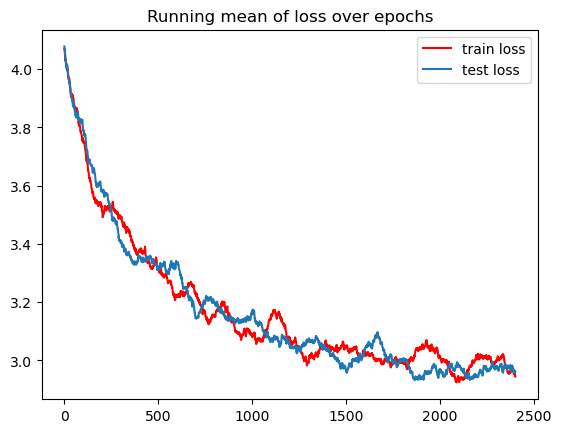

In [13]:
loss_over_time= np.loadtxt('./train_loss.txt',skiprows=1, delimiter='\t', usecols=(0), unpack=True)
test_error= np.loadtxt('./test_loss.txt',skiprows=1, delimiter='\t', usecols=(0), unpack=True)


N=100
plt.plot(np.convolve(loss_over_time, np.ones(N)/N, mode='valid'),c='red',label='train loss')
plt.plot(np.convolve(test_error, np.ones(N)/N, mode='valid'),label='test loss')
plt.title('Running mean of loss over epochs')
plt.legend()

print(stop)

In [14]:
a=np.linspace(0.01,1,num=1)
#a=[0.1]

transformer.load_state_dict(torch.load('AttTrack2_new.pt',map_location=torch.device('cpu')))
transformer.eval()
convert_tensor = transforms.ToTensor()
lo=[]
for k in range(len(a)):
    print(lo)
    print('k---',k)
    g=[]
    for v in range(10):
        #print('v-',v)


        src1, src2, y,d = collate_fn(1,-100,train=False)

        src1= src1.to(DEVICE)
        src2= src2.to(DEVICE)



        src_padding_mask1=create_mask(src1,-100)
        src_padding_mask2=create_mask(src2,-100)

        Ad = transformer(src1,src2,src_padding_mask1,src_padding_mask2)
        #print(Ad[0])

        Ad_real = complete_postprocess(Ad,d,a[k])
        #print(Ad_real[0])
        #print(y[0])
        
        Ad_real= convert_tensor(Ad_real[0])


        l = nn.CrossEntropyLoss()
        s = l(Ad_real[0], y[0])
        g.append(s)
    lo.append(np.mean(g))

plt.plot(a,lo)






[]
k--- 0


RuntimeError: "log_softmax_lastdim_kernel_impl" not implemented for 'Long'

#postprocess Training


transformer = AdjacencyTransformer(num_encoder_layers, emb_size, nhead)


NUM_EPOCHS=1000


transformer = transformer.to(DEVICE)

loss_fn = Loss(pen=0,tra_to_tens=True)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.00001, betas=(0.9, 0.98), eps=1e-9)

loss_over_time=[]
test_error=[]

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch_post_process(transformer, optimizer,loss_fn)
    end_time = timer()
    
    
    loss_over_time.append(train_loss)
    np.savetxt('./'+'train_loss_pp.txt', np.c_[loss_over_time],delimiter='\t',header='trainloss')
    
    

    
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    
#torch.save(transformer.state_dict(), 'AttTrack24.pt')

In [15]:
#recon+testerror
for r in range(1,3):
    r=8
    src1, src2, y,d = collate_fn(31,-100,recon=True,train=False,run=r)

    #print(src1.size())
    src1= src1.to(DEVICE)
    src2= src2.to(DEVICE)
    
    src_padding_mask1=create_mask(src1,-100)
    src_padding_mask2=create_mask(src2,-100)
    
    
    #transformer.load_state_dict(torch.load('AttTrack_2.pt',map_location=torch.device('cpu')))
    transformer.eval()
    
    

    Ad = transformer(src1,src2,src_padding_mask1,src_padding_mask2)
    
    val_loss = evaluate(transformer,loss_fn)
    #print('L',val_loss)
    a=0.1
    #print(Ad)
    #pp_A = complete_postprocess(Ad,d,a)
    
    #err_p=err_perc(pp_A,y)
    #print('err',r,err_p)

#print(src1.size())

    print('y',y[6])
    print('Ad',Ad[6])
    #print('pp',pp_A[6])
    #print('d',d[6])

#for i in range(5):
#    print(pp_A[i])
    
    
    make_reconstructed_edgelist(Ad,run=r)

y tensor([[1., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]])
Ad tensor([[1.0000e+00, 1.3208e-11, 3.2145e-14, 1.0000e+00, 2.5342e-11],
        [3.6520e-11, 6.9168e-12, 1.8871e-09, 8.2978e-11, 1.0000e+00],
        [6.1533e-13, 5.4397e-12, 1.0000e+00, 1.4898e-08, 1.4453e-07],
        [1.8162e-11, 1.0000e+00, 2.5861e-15, 2.1749e-10, 2.7834e-13]],
       grad_fn=<SliceBackward0>)
M0 tensor([[1.0000e+00, 2.3077e-13, 1.2035e-07, 1.0327e-12],
        [9.7723e-12, 1.0000e+00, 4.4373e-12, 5.3588e-11],
        [2.9410e-10, 3.8465e-07, 1.0000e+00, 1.6540e-13],
        [1.5394e-13, 5.1452e-12, 2.7423e-05, 1.0000e+00]],
       grad_fn=<SliceBackward0>)
M0 tensor([[1.0000e+00, 4.5780e-15, 2.4484e-12, 5.4531e-08],
        [1.2219e-11, 1.0000e+00, 4.8334e-16, 1.1085e-07],
        [2.5520e-09, 5.2584e-13, 1.0264e-13, 1.0000e+00],
        [1.7476e-13, 2.9836e-09, 1.0000e+00, 4.0618e-17]],
       grad_fn=<SliceBackward0>)
M0 tensor([[1.0000e+00

M0 tensor([[1.0000e+00, 6.8383e-10, 9.0930e-09, 1.3986e-08, 1.8819e-08, 4.1949e-08,
         1.0000e+00, 4.1769e-09, 4.3367e-13, 2.8554e-07, 1.6143e-15],
        [2.0469e-08, 7.1848e-07, 2.9045e-15, 3.7606e-07, 4.3900e-09, 1.0000e+00,
         1.4761e-06, 1.2315e-14, 1.1064e-08, 1.5698e-11, 5.1876e-07],
        [7.8796e-09, 3.3622e-07, 1.0503e-05, 6.7457e-07, 1.0000e+00, 3.3308e-08,
         6.3305e-09, 1.6413e-08, 6.0453e-07, 8.8765e-09, 6.9906e-10],
        [1.2833e-09, 2.5090e-08, 2.8234e-13, 1.0000e+00, 2.5776e-12, 2.1368e-06,
         2.7721e-12, 3.1815e-07, 2.6644e-06, 4.3113e-08, 1.2655e-06],
        [1.5742e-14, 4.4747e-10, 8.8404e-09, 1.5555e-07, 2.1074e-08, 8.9317e-12,
         4.7281e-13, 3.4364e-08, 1.0000e+00, 2.2123e-07, 5.8744e-10],
        [4.2299e-09, 1.0000e+00, 2.3729e-07, 9.3055e-15, 8.8722e-08, 5.1156e-06,
         1.7341e-08, 1.1368e-13, 5.8183e-07, 9.5011e-06, 4.7908e-07],
        [1.4219e-11, 5.7207e-07, 1.0000e+00, 1.2491e-16, 3.4321e-06, 2.0263e-12,
         3

M0 tensor([[1.0000e+00, 4.5812e-08, 8.0000e-08, 5.7235e-06, 9.0963e-11, 1.0000e+00,
         2.4902e-11, 1.3578e-05, 2.4258e-08, 7.3952e-13, 1.6545e-08, 5.6285e-09,
         1.3241e-06, 6.3093e-14, 1.6255e-10, 1.2161e-08],
        [4.9032e-14, 2.1791e-05, 1.8081e-18, 3.2173e-06, 2.3294e-03, 5.5915e-13,
         4.3110e-14, 6.3750e-04, 1.4278e-08, 5.7221e-15, 3.7959e-17, 1.3531e-06,
         2.0402e-12, 8.7915e-05, 1.0000e+00, 7.8634e-08],
        [7.0489e-06, 3.8145e-12, 2.0428e-14, 7.6153e-07, 1.7457e-13, 6.8771e-05,
         4.3881e-11, 8.1119e-04, 2.1806e-07, 8.7115e-07, 5.5801e-07, 1.0000e+00,
         4.0270e-19, 2.0829e-03, 1.8114e-04, 1.3471e-07],
        [6.2384e-10, 1.2492e-08, 4.2202e-10, 3.0724e-10, 2.9506e-15, 3.7966e-08,
         1.7727e-15, 8.1248e-09, 1.0000e+00, 3.3908e-06, 2.6556e-06, 1.0488e-08,
         1.1701e-05, 3.9001e-14, 2.3419e-08, 1.0000e+00],
        [8.3778e-06, 1.0000e+00, 7.1890e-10, 4.3633e-14, 5.5901e-04, 1.2625e-06,
         3.2644e-05, 2.8506e-09, 5.1

y tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.]])
Ad tensor([[1.0000e+00, 3.2020e-12, 1.6379e-12, 4.8769e-11, 4.9058e-11],
        [1.2388e-10, 1.0000e+00, 6.3422e-13, 1.0000e+00, 5.8920e-15],
        [4.8584e-12, 3.9758e-07, 7.4334e-14, 1.0835e-10, 1.0000e+00],
        [2.5032e-15, 4.0213e-11, 1.0000e+00, 4.7466e-10, 1.1454e-08]],
       grad_fn=<SliceBackward0>)
M0 tensor([[1.0000e+00, 5.2496e-13, 4.3161e-11, 1.3953e-12],
        [1.1566e-10, 1.2822e-12, 3.2388e-14, 1.0000e+00],
        [6.1699e-12, 9.7385e-12, 1.0000e+00, 3.4181e-14],
        [1.0847e-10, 1.0000e+00, 7.3919e-12, 2.8089e-14]],
       grad_fn=<SliceBackward0>)
M0 tensor([[1.0000e+00, 1.7940e-13, 1.0000e+00, 4.5528e-13, 1.4021e-11],
        [1.2389e-12, 6.7078e-10, 4.8816e-10, 2.7167e-13, 1.0000e+00],
        [2.9213e-10, 1.0000e+00, 3.5516e-09, 8.3490e-16, 8.5991e-08],
        [1.8215e-08, 6.6176e-14, 1.4573e-10, 1.0000e+00, 1.3072e-16]],
       

M0 tensor([[1.0000e+00, 3.1592e-16, 1.9636e-09, 3.4317e-13, 4.1179e-15, 4.6582e-07,
         2.9175e-11, 2.4692e-08, 4.1774e-06, 8.0590e-07],
        [6.2459e-11, 3.9834e-09, 1.0037e-11, 7.8639e-06, 3.3353e-05, 8.0210e-13,
         1.7775e-08, 4.6322e-14, 1.8463e-14, 1.0000e+00],
        [8.1751e-11, 2.8165e-05, 6.0061e-19, 1.0000e+00, 1.6190e-11, 4.1116e-15,
         5.4136e-08, 4.9514e-08, 1.7905e-07, 4.7167e-07],
        [1.9391e-09, 6.3253e-07, 1.5844e-06, 4.2218e-11, 1.0000e+00, 2.0911e-12,
         1.7971e-07, 1.1632e-06, 2.9971e-06, 8.1487e-07],
        [3.2061e-06, 2.2442e-06, 1.2016e-07, 4.1415e-10, 4.7307e-07, 6.8830e-14,
         1.0000e+00, 1.5375e-07, 5.8858e-18, 2.6894e-07],
        [2.0822e-08, 6.5055e-06, 2.0525e-13, 5.6345e-06, 3.2037e-15, 5.8709e-04,
         2.9712e-17, 1.4295e-08, 1.0000e+00, 2.5107e-14],
        [3.2446e-13, 1.0000e+00, 2.6242e-12, 7.1597e-06, 3.7594e-12, 2.4687e-08,
         6.1408e-09, 3.4795e-10, 1.9889e-05, 5.9245e-11],
        [6.7529e-06, 3.5

M0 tensor([[1.0000e+00, 1.1996e-12, 1.0255e-11, 2.0220e-07, 5.7017e-07, 2.1454e-06,
         4.8091e-08, 1.0000e+00, 9.5154e-10, 1.0232e-14, 1.4152e-12, 2.2612e-09,
         5.5220e-13, 7.5752e-09],
        [9.3027e-08, 1.2644e-05, 9.4885e-05, 1.0000e+00, 7.0743e-16, 1.3051e-11,
         1.1569e-17, 1.7563e-06, 6.0237e-06, 2.7243e-08, 1.3370e-17, 8.3696e-07,
         6.0274e-08, 3.1208e-15],
        [7.2693e-11, 2.6343e-11, 1.0000e+00, 1.3955e-05, 2.1027e-11, 2.7942e-12,
         1.5236e-06, 6.8884e-11, 1.0000e+00, 1.1325e-05, 2.4358e-08, 6.4577e-11,
         3.6428e-07, 7.6886e-21],
        [1.7958e-11, 1.5413e-09, 3.3569e-05, 1.0839e-14, 4.0876e-08, 4.2644e-11,
         1.0731e-04, 1.3368e-13, 4.7266e-09, 1.1295e-05, 1.0000e+00, 3.3064e-08,
         5.8995e-05, 2.8600e-10],
        [1.3002e-08, 2.0627e-10, 5.3731e-13, 6.3530e-05, 1.0270e-05, 1.2735e-14,
         1.3824e-10, 1.2224e-06, 6.0207e-06, 7.0138e-15, 3.0967e-08, 1.0000e+00,
         1.5269e-07, 2.0257e-12],
        [8.3994e-

In [ ]:
print(stop)

In [ ]:
#Umap AdjacencyTrans2


emb_size= 150 ###!!!!24 for n2v emb
nhead= 6    ###!!!! 6 for n2v emb
num_encoder_layers = 3


transformer = AdjacencyTransformer_2(num_encoder_layers, emb_size, nhead,out=True)



for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = Loss(pen=0)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.load_state_dict(torch.load('AttTrack_2.pt',map_location=torch.device('cpu')))


NUM_EPOCHS = 2

loss_over_time=[]
test_error=[]

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer,loss_fn)
    end_time = timer()
    val_loss = evaluate(transformer,loss_fn)
    
    
    loss_over_time.append(train_loss)
    np.savetxt('./'+'train_loss_Ad2.txt', np.c_[loss_over_time],delimiter='\t',header='trainloss')
    
    test_error.append(val_loss)
                
    np.savetxt('./'+'test_loss_Ad2.txt', np.c_[test_error],delimiter='\t',header='testloss')

    
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    

    
    
    
loss_over_time= np.loadtxt('./train_loss_Ad2.txt',skiprows=1, delimiter='\t', usecols=(0), unpack=True)
test_error= np.loadtxt('./test_loss_Ad2.txt',skiprows=1, delimiter='\t', usecols=(0), unpack=True)


N=1

plt.plot(np.convolve(np.log10(loss_over_time), np.ones(N)/N, mode='valid'),c='red')
plt.plot(np.convolve(np.log10(test_error), np.ones(N)/N, mode='valid'))    



In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import umap.umap_ as umap


transformer.load_state_dict(torch.load('AttTrack_2.pt',map_location=torch.device('cpu')))
transformer.eval()

run=95
t= 8
src1, src2, y,d = collate_fn(31,-100,recon=True,train=False,run=run)
src_padding_mask1=create_mask(src1,-100)
src_padding_mask2=create_mask(src2,-100)


Ad,out1,out2,out_dec1,src_t1,src_t2 = transformer(src1,src2,src_padding_mask1,src_padding_mask2)



out_dec1=torch.transpose(out_dec1,2,1)
out_dec1=torch.transpose(out_dec1,1,0)
print(out_dec1.shape)


src_t1=src_t1[:,t,:]#[1:]
src_t2=src_t2[:,t,:]#[1:]

ind1=np.where(src_t1 == -100)
ind2=np.where(src_t2 == -100)

a=out1.detach().numpy()
b=out_dec1.detach().numpy()

a=a[:,t,:]#[1:]
b=b[:,t,:]#[1:]

a=a[0:ind1[0][0]]

b=b[0:ind2[0][0]]




blue_list=['#2a186c','#2e1f98','#1a3b9f','#0c5294','#16638d','#25738a','#328388','#3c9387','#45a383','#53b47c','#69c46f']
red_list=['#2f0303','#6e0302','#9a0303','#c40303','#f30203','#ff1f03','#ff4a04','#fe7104','#ffa001','#fec701','#fef903']
c_list=[]

for p in range(len(a)):
    c_list.append(blue_list[p])
    
for t in range(len(b)):
    c_list.append(red_list[t])

#print(c_list)
c_list=['blue']*len(a)+['black']*len(b)

#print(src_t1.shape)

src=np.vstack((a,b))

'''
mnist = fetch_openml("mnist_784", version=1)
X_train, X_test, y_train, y_test = train_test_split(
    mnist.data, mnist.target, stratify=mnist.target, random_state=42
)
'''
print(src.shape)
reducer = umap.UMAP(metric='cosine',n_neighbors=4)
embedding = reducer.fit_transform(src)
#print(embedding_train,embedding_train.shape)
#embedding_test = reducer.transform(X_test)
print(embedding)
plt.scatter(embedding[:, 0],embedding[:, 1],c=c_list)
plt.gca().set_aspect('equal')
'''[[11.102701   9.834718 ]
 [10.975245  11.376655 ]
 [11.55883   10.9941   ]
 [10.942158  10.440168 ]
 [10.304249  10.682447 ]
 [10.096922  10.017049 ]
 [10.49952   12.192604 ]
 [ 8.663966  11.4105625]
 [ 9.177266  12.255981 ]
 [ 8.936496  10.613881 ]
 [10.011719  11.911004 ]
 [ 9.29462   11.477478 ]
 [ 9.607173  10.698044 ]]'''

#plt.savefig('./umap_1_12_16.png',transparent=False)
#plt.savefig('./umap_1_12_16.png',transparent=False)

In [ ]:
tsne = TSNE(n_components=2)
print(src.shape)
tsne_results = tsne.fit_transform(src)



print(tsne_results)

plt.scatter(tsne_results[:,0],tsne_results[:,1],c=c_list)
plt.gca().set_aspect('equal')
#plt.savefig('./tsne_1_12_16.png',transparent=False)